# Notebook I - Climate Regime
<hr>
This module performs climate data analysis and compiling general agro-climatic indicators. These general agro-climatic indicators summarize climatic profiles in the study area for each grid. The key input data for this module is the climatic data, and the geographical and terrain data.

Prepared by Geoinformatics Center, AIT
<hr>


### Google drive connection
In this step, we will connect to Google Drive service and mount the drive where we will start our PyAEZ project

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)

Then, installing any additional python packages that required to run PyAEZ.
If working on your own PC/machine, these additional installation will vary depending on what is already installed in your Python library. 

In [ ]:
# 'Installing neccessary packages'
# !pip install gdal

Now, we will import the specific Python packages we need for PyAEZ.

In [1]:
'''import supporting libraries'''
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
try:
    from osgeo import gdal
except:
    import gdal
import sys
import colorcet as cc

Setting the working directory -- where our PyAEZ project is located.

In [2]:
# branch version tag
revname='v21'
domain='china'

# Kerrie laptop
work_dir = r'C://Users/kerrie/Documents/01_LocalCode/repos/PyAEZ/pyaez2.1/pyaez2.1_2023OCT23/' # path to your PyAEZ repo
out_path = work_dir+'NB1outputs/' # path for saving output data
dir_toplev=r'C://Users/kerrie/Documents/01_LocalCode/'
# china
data_dir = r'C://Users/kerrie/Documents/02_LocalData/pyAEZ_input_data/china/npy/' # path to your data
maskfile = r'C://Users/kerrie/Documents/02_LocalData/pyAEZ_input_data/china/tif/mask.tif'# subset for no antarctica, 1800 lats
elevfile = r'C://Users/kerrie/Documents/02_LocalData/pyAEZ_input_data/china/tif/elev.tif'
soilfile = r'C://Users/kerrie/Documents/02_LocalData/pyAEZ_input_data/china/tif/soil_terrain_lulc_china_08333.tif'

mask_path=maskfile

# Check whether the specified path exists or not
isExist = os.path.exists(out_path)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(out_path)
   print("The new directory is created!")

Check and create data output folder

In [3]:
# import os
# folder_path = './data_output/NB1/'
# if not os.path.exists(folder_path):
#     os.makedirs(folder_path)
#     print("Folder created successfully.")
# else:
#     print("Folder already exists.")


<hr>

## MODULE 1: CLIMATE REGIME
Now, we will start executing the routines in Module 1


First, we initiate Module 1 Class instance by invoking the following commands:

In [4]:
# %load_ext autoreload
# %autoreload 2
# # Import Module 1 and initate Class intance
# from pyaez import ClimateRegime
# clim_reg = ClimateRegime.ClimateRegime()

# # Importing UtilitiesCalc
# from pyaez import UtilitiesCalc
# obj_util = UtilitiesCalc.UtilitiesCalc()


sys.path.append(work_dir)

import ClimateRegime as ClimateRegime
clim_reg = ClimateRegime.ClimateRegime()

import UtilitiesCalc as UtilitiesCalc
obj_utilities=UtilitiesCalc.UtilitiesCalc()

### Importing the climate dataset and the geographical data/rasters.

The package expects six climate variables, as daily or monthly observations, as Numpy arrays.
Arrays must be 3-dimensional, with the third axes containing the time dimension.
Unit of measures are expected as follows:
- Minimum temperature = Degree Celsius
- Maximum temperature = Degree Celsius
- Precipitation = Accumulated mm / day (or per month)
- Solar radiation = W/m^2
- Wind speed = Average m/s
- Relative humidity = Average fraction (0 to 1)

In addition to climate data, the system requires:
- A binary admin_mask, with 0 and 1 values. 0 pixels values will be not executed, while 1 pixels values will be executed
- An elevation layer
- Soil/terrain/special land cover classes
  

**All the datasets must have the same shape.**

In [5]:
# '''reading climate data'''
# # Importing the climate data
# max_temp = np.load(r'./data_input/climate/max_temp.npy')  # maximum temperature
# min_temp = np.load(r'./data_input/climate/min_temp.npy')  # minimum temperature
# precipitation = np.load(r'./data_input/climate/precipitation.npy')  # precipitation
# rel_humidity = np.load(r'./data_input/climate/relative_humidity.npy')  # relative humidity
# wind_speed = np.load(r'./data_input/climate/wind_speed.npy') # wind speed measured at two meters
# short_rad = np.load(r'./data_input/climate/short_rad.npy')  # shortwave radiation

# # Load the geographical data/rasters
# mask_path='./data_input/LAO_Admin.tif'
# mask = gdal.Open(mask_path).ReadAsArray()
# elevation = gdal.Open(r'./data_input/LAO_Elevation.tif').ReadAsArray()
# soil_terrain_lulc = gdal.Open(r'./data_input/LAO_soil_terrain_lulc.tif').ReadAsArray()

max_temp = np.load(data_dir+'Tmax-2m365/0.npy').astype('float32')  # maximum temperature
min_temp = np.load(data_dir+'Tmin-2m365/0.npy').astype('float32')  # minimum temperature
precipitation = np.load(data_dir+'Precip365/0.npy').astype('float32')  # precipitation
rel_humidity = np.load(data_dir+'Rhum365/0.npy').astype('float32')  # relative humidity
wind_speed = np.load(data_dir+'Wind-2m365/0.npy').astype('float32') # wind speed measured at two meters
short_rad = np.load(data_dir+'Srad365/0.npy').astype('float32')  # shortwave radiation
mask=gdal.Open(maskfile).ReadAsArray()
elevation=gdal.Open(elevfile).ReadAsArray()
soil_terrain_lulc=gdal.Open(soilfile).ReadAsArray()

c:\Users\kerrie\.conda\envs\pyaez_dask\Lib\site-packages\osgeo\gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


This section contains parameters that can be modified by the user:
- lat_min = minimum latitude of analysis
- lat_max = maximum latitude of analysis
- mask_value = the value in the admin_mask to exclude from the analysis (typically 0)
- daily = whether climate input data are daily (True) or monthly (False)

In [6]:
# Define the Area-Of-Interest's geographical extents
lat_min = 18.0
lat_max = 53.66667
mask_value = 0  # pixel value in admin_mask to exclude from the analysis
daily = True #Type of climate data = True: daily, False: monthly

### Loading the imported data into the Object Class ('*clim_reg*' Class)

In [7]:
clim_reg.setStudyAreaMask(mask, mask_value)
clim_reg.setLocationTerrainData(lat_min, lat_max, elevation)
if daily:
    clim_reg.setDailyClimateData(
        min_temp, max_temp, precipitation, short_rad, wind_speed, rel_humidity)
else:
    clim_reg.setMonthlyClimateData(
        min_temp, max_temp, precipitation, short_rad, wind_speed, rel_humidity)

In [8]:
'Releasing the memory of input climate data -- free up some RAM space'
del(min_temp, max_temp, precipitation, short_rad, wind_speed, rel_humidity)

In [9]:
print(clim_reg.__dict__.keys())


dict_keys(['im_mask', 'nodata_val', 'set_mask', 'elevation', 'im_height', 'im_width', 'latitude', 'meanT_daily', 'totalPrec_daily', 'pet_daily', 'maxT_daily', 'minT_daily', 'meanT_daily_sealevel', 'P_by_PET_daily', 'set_monthly'])


In [10]:
clim_reg.latitude

array([[53.625  , 53.625  , 53.625  , ..., 53.625  , 53.625  , 53.625  ],
       [53.54166, 53.54166, 53.54166, ..., 53.54166, 53.54166, 53.54166],
       [53.45833, 53.45833, 53.45833, ..., 53.45833, 53.45833, 53.45833],
       ...,
       [18.20833, 18.20833, 18.20833, ..., 18.20833, 18.20833, 18.20833],
       [18.125  , 18.125  , 18.125  , ..., 18.125  , 18.125  , 18.125  ],
       [18.04166, 18.04166, 18.04166, ..., 18.04166, 18.04166, 18.04166]])

NOTE: After loading the data into the *clim_reg* Class, all the parameters will be converted to DAILY DATA and calculated as other parameters. 
These new parameters are available and can be called into use as:
- *clim_reg.minT_daily* (minimum temperature)
- *clim_reg.maxT_daily* (maximum temperature)
- *clim_reg.meanT_daily* (mean temperature)
- *clim_reg.meanT_daily_sealevel* (mean temperature, corrected to sea-level)
- *clim_reg.totalPrec_daily* (total precipitation)
- *clim_reg.pet_daily* (reference evapotranspiration, ETo)
- *clim_reg.P_by_PET_daily* (ratio of precipitation over ETo)
  


#### Thermal Climate
The Thermal Climate function calculates and classifies latitudinal thermal climate, which will be used later in Module 2 for the assessment of potential crops and land utilization types (LUT) presence in each grid cell.

In [11]:
# meanT_monthly_sealevel=np.empty((clim_reg.im_height,clim_reg.im_width,12),dtype='float32')
# meanT_monthly=np.empty((clim_reg.im_height,clim_reg.im_width,12),dtype='float32')
# PbyPET_monthly=np.empty((clim_reg.im_height,clim_reg.im_width,12),dtype='float32')
# obj_utilities = UtilitiesCalc.UtilitiesCalc()
# for i_row in range(clim_reg.im_height):
#     for i_col in range(clim_reg.im_width):
#         meanT_monthly_sealevel[i_row,i_col,:] = obj_utilities.averageDailyToMonthly(clim_reg.meanT_daily_sealevel[i_row,i_col,:])
#         meanT_monthly[i_row,i_col,:] = obj_utilities.averageDailyToMonthly(clim_reg.meanT_daily[i_row,i_col,:])        
#         PbyPET_monthly[i_row,i_col,:] = obj_utilities.averageDailyToMonthly(clim_reg.P_by_PET_daily[i_row,i_col,:])                

In [12]:
# plt.figure(figsize=(12,3))
# plt.subplot(1, 2, 1)
# plt.imshow(PbyPET_monthly[:,:,0],vmin=0,vmax=20,interpolation='none')
# plt.title('PbyPET')
# plt.colorbar()

c:\Users\kerrie\.conda\envs\pyaez_dask\Lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


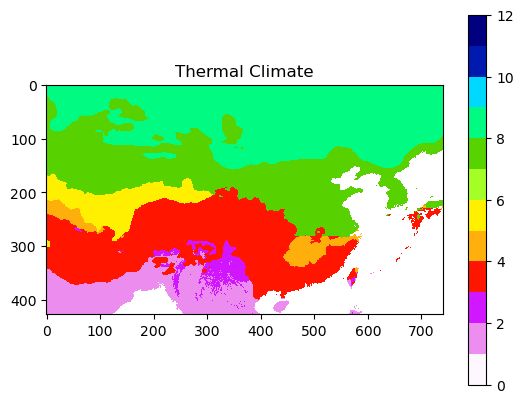

In [13]:
tclimate = clim_reg.getThermalClimate()

fig = plt.figure()
plt.imshow(tclimate, cmap=plt.get_cmap('gist_ncar_r', 12),vmin=0,vmax=12,interpolation='none')
plt.title('Thermal Climate')
plt.colorbar()

plt.savefig(out_path+"ThermalClimate_"+domain+"_"+revname+".png",bbox_inches="tight", dpi=600)
plt.show()


obj_utilities.saveRaster(maskfile,out_path+"ThermalClimate_"+domain+"_"+revname+".tif",tclimate) #Save as GeoTIFF raster


#### Thermal Zone
The thermal zone is classified based on actual temperature which reflects on the temperature regimes of major thermal climates

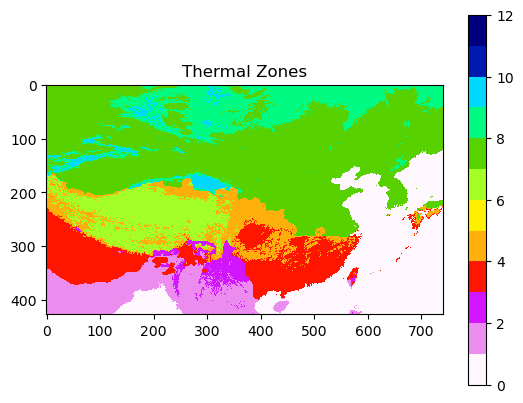

In [14]:
tzone = clim_reg.getThermalZone()

fig = plt.figure()
plt.imshow(tzone.astype(int), cmap=plt.get_cmap('gist_ncar_r', 12),vmin=0,vmax=12,interpolation='none')
plt.title('Thermal Zones')
plt.colorbar()

plt.savefig(out_path+"ThermalZone_"+domain+"_"+revname+".png",bbox_inches="tight", dpi=600)
plt.show()

obj_utilities.saveRaster(maskfile,out_path+"ThermalZone_"+domain+"_"+revname+".tif",tzone) #Save as GeoTIFF raster

#### Thermal Length of Growing Period (LGP)
The thermal length of growing period (LGPt) is defined as the number of days in a year during which the daily mean temperature (Ta) is conductive to crop growth and development. PyAEZ utilizes the AEZ three standard temperature thresholds for LGPt:
- Periods with Ta>0°C (LGPt0)
- Periods with Ta>5°C (LGPt5) – the period conductive to plant growth and development
- Periods, and Ta>10°C (LGPt10) – a proxy for the period of low risks for late and early frost occurrences and termed ‘frost-free period’

In [15]:
lgpt0 = clim_reg.getThermalLGP0()
lgpt5 = clim_reg.getThermalLGP5()
lgpt10 = clim_reg.getThermalLGP10()

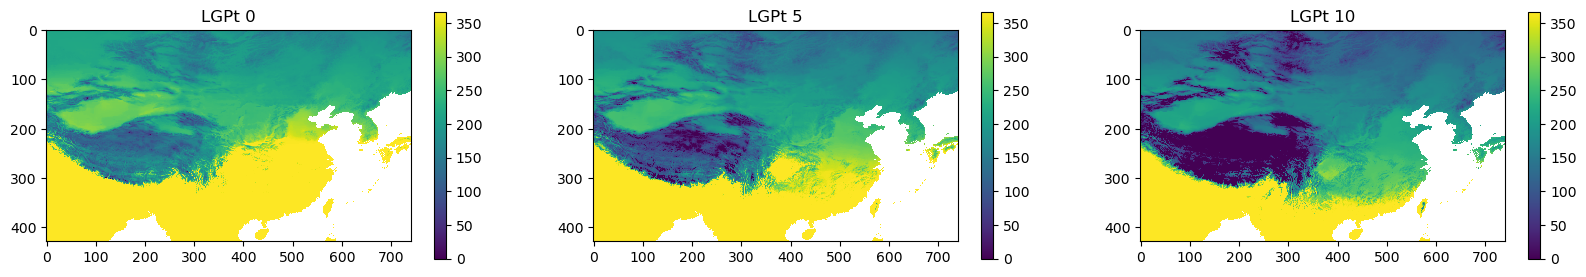

In [16]:
plt.figure(figsize=(20,4))
plt.subplot(1, 3, 1)
plt.imshow(lgpt0,vmin=0,vmax=366,interpolation='none')
plt.title('LGPt 0')
plt.colorbar(shrink=0.8)
#----------------------
plt.subplot(1, 3, 2)
plt.imshow(lgpt5, vmin=0, vmax=366,interpolation='none')
plt.title('LGPt 5')
plt.colorbar(shrink=0.8)
#----------------------
plt.subplot(1, 3, 3)
plt.imshow(lgpt10, vmin=0, vmax=366,interpolation='none')
plt.title('LGPt 10')
plt.colorbar(shrink=0.8)
#----------------------

# plt.savefig(out_path+"ThermalLGPs_"+domain+"_"+revname+".png",bbox_inches="tight", dpi=600)
plt.show()

obj_utilities.saveRaster(maskfile,out_path+"LGPt0_"+domain+"_"+revname+".tif",lgpt0) #Save as GeoTIFF raster
obj_utilities.saveRaster(maskfile,out_path+"LGPt5_"+domain+"_"+revname+".tif",lgpt5) #Save as GeoTIFF raster
obj_utilities.saveRaster(maskfile,out_path+"LGPt10_"+domain+"_"+revname+".tif",lgpt10) #Save as GeoTIFF raster


#### Temperature Sum

In [17]:
tsum0 = clim_reg.getTemperatureSum0()
tsum5 = clim_reg.getTemperatureSum5()
tsum10 = clim_reg.getTemperatureSum10()

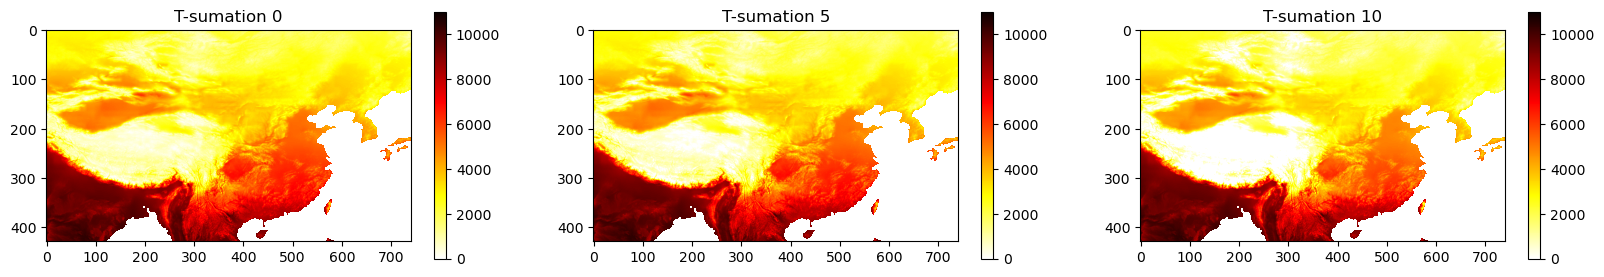

In [18]:
'''save and visualize result'''
#======================
plt.figure(1, figsize=(20, 4))
plt.subplot(1, 3, 1)
plt.imshow(tsum0, cmap='hot_r', vmin=0, vmax=11000)
plt.title('T-sumation 0')
plt.colorbar(shrink=0.8)
#----------------------
plt.subplot(1, 3, 2)
plt.imshow(tsum5, cmap='hot_r', vmin=0, vmax=11000)
plt.title('T-sumation 5')
plt.colorbar(shrink=0.8)
#----------------------
plt.subplot(1, 3, 3)
plt.imshow(tsum10, cmap='hot_r', vmin=0, vmax=11000)
plt.title('T-sumation 10')
plt.colorbar(shrink=0.8)
#----------------------
# plt.savefig("./data_output/NB1/LAO_Tsum.png",
#             bbox_inches="tight", dpi=300)
plt.show()
#======================

obj_utilities.saveRaster(maskfile,out_path+"Tsum0_"+domain+"_"+revname+".tif",tsum0) #Save as GeoTIFF raster
obj_utilities.saveRaster(maskfile,out_path+"Tsum5_"+domain+"_"+revname+".tif",tsum5) #Save as GeoTIFF raster
obj_utilities.saveRaster(maskfile,out_path+"Tsum10_"+domain+"_"+revname+".tif",tsum10) #Save as GeoTIFF raster


#### Temperature Profile

In [ ]:
tprofile = clim_reg.getTemperatureProfile()

In [ ]:
'''save and visualize result'''

tile_list = ['A9', 'A8', 'A7', 'A6', 'A5', 'A4', 'A3', 'A2',
             'A1', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9']

fig = plt.figure(figsize=(12, 20))
for i1 in range(1, 19):
    plt.subplot(6, 3, i1)
    plt.imshow(tprofile[i1-1])
    plt.title(tile_list[i1-1])
    plt.colorbar(shrink=0.9)
plt.tight_layout()

# plt.savefig("./data_output/NB1/LAO_Tprofiles.png",
#             bbox_inches="tight", dpi=300)
plt.show()

for i1 in range(18):
    obj_utilities.saveRaster(maskfile,out_path+"TProfile_"+tile_list[i1]+"_"+domain+"_"+revname+".tif",tprofile[i1]) #Save as GeoTIFF raster

#### Length of Growing Periods (LGPs)

In [19]:
lgp = clim_reg.getLGP(Sa=100., D=1.)
lgp_class = clim_reg.getLGPClassified(lgp)
lgp_equv = clim_reg.getLGPEquivalent()

In [ ]:
# '''save and visualize result'''

plt.imshow(lgp, cmap='viridis', vmin=0, vmax=366, interpolation='none')
plt.title('LPG [days]')
plt.colorbar()
# plt.savefig("./data_output/NB1/LAO_LGP.png", bbox_inches="tight", dpi=300)
plt.show()


plt.imshow(lgp_equv, cmap='viridis', vmin=0, vmax=366, interpolation='none')
plt.title('LPG Equivalent [days]')
plt.colorbar()
# plt.savefig("./data_output/NB1/LAO_LGP_Equv.png",
            # bbox_inches="tight", dpi=300)
plt.show()

obj_utilities.saveRaster(maskfile,out_path+"LGP_"+domain+"_"+revname+".tif",lgp) #Save as GeoTIFF raster
obj_utilities.saveRaster(maskfile,out_path+"LGPEquivalent_"+domain+"_"+revname+".tif",lgp_equv) #Save as GeoTIFF raster


In [ ]:
clim_reg.__dict__.keys()

In [ ]:
# clim_reg.eta_class.shape,clim_reg.Eta365.shape

In [ ]:
# ####################################################################
# ####### dont forget to delete this #################################
# ####### DEBUGGING LGPCalc.py, exporting different variables ########
# ####################################################################
# import pandas as pd
# import xarray as xr
# import rioxarray as rio

# #### user update here ####
# varname='Etm365'#'lgp'#'islgp'#'yy'#'Wb365'#'Eta365'#'Eto365'#'snm365'#'Sb365'#'p'#
# var=clim_reg.__getattribute__(varname)
# ##########################

# out_dir=work_dir+'debug/'
# filename=varname+'_repoOCT_LGPCalc.nc'
# year=1980            
# time=pd.date_range(str(year)+'-01-01',str(year)+'-12-31',freq='D')
# if len(time) != lgp.shape[-1]:
#     time=time[~(time==str(year)+'-02-29')]
# lons=rio.open_rasterio(maskfile)['x'].data
# lons=np.trunc(lons*100000)/100000
# lats=rio.open_rasterio(maskfile)['y'].data
# lats=np.trunc(lats*100000)/100000

# # metadata for output data files
# timeattrs={'standard_name':'time','long_name':'time','axis':'T'}
# latattrs={'standard_name':'latitude','long_name':'latitude','units':'degrees_north','axis':'Y'}
# lonattrs={'standard_name':'longitude','long_name':'longitude','units':'degrees_east','axis':'X'}

# # encoding info for writing netcdf files
# time_encoding={'calendar':'standard','units':'days since 1900-01-01 00:00:00','_FillValue':None}
# lat_encoding={'_FillValue':None,'dtype':'float32'}
# lon_encoding={'_FillValue':None,'dtype':'float32'}
# var_encoding = {'zlib':True,'dtype':'float32'}

# if len(var.shape)==3:
#     var_xr=xr.DataArray(var,
#             dims=['lat','lon','time'],
#             coords={'lat':('lat',lats),'lon':('lon',lons),'time':('time',time)}).astype('float32')
# if len(var.shape)==2:
#     var_xr=xr.DataArray(var,
#         dims=['lat','lon'],
#         coords={'lat':('lat',lats),'lon':('lon',lons)}).astype('float32')            
# var_xr.name=varname
# var_xr['lat'].attrs=latattrs
# var_xr['lon'].attrs=lonattrs
# var_xr.attrs={'description':varname+' from LGPCalc.py'}
# var_xr=var_xr.to_dataset()
# # write mask netcdf file
# var_xr.to_netcdf(out_dir+filename,
#             encoding={'lat':lat_encoding,'lon':lon_encoding,varname:var_encoding})  
# ####################################################################
# ####################################################################
# ####################################################################
# ####################################################################

In [ ]:
# # clim_reg.Eta365.shape
# obj_utilities.saveRaster(maskfile,out_path+"istart0_"+domain+"_"+revname+".tif",clim_reg.istart0) #Save as GeoTIFF raster
# obj_utilities.saveRaster(maskfile,out_path+"istart1_"+domain+"_"+revname+".tif",clim_reg.istart1) #Save as GeoTIFF raster

In [ ]:
# plt.imshow(clim_reg.istart0, cmap='viridis', vmin=0, vmax=366,interpolation='none')
# plt.title('istart0')
# plt.colorbar()
# plt.show()

# plt.imshow(clim_reg.istart1, cmap='viridis', vmin=0, vmax=366,interpolation='none')
# plt.title('istart1')
# plt.colorbar()
# plt.show()

#### Multi Cropping Zone
Multiple cropping zones classification is an additional agro-climatic indicator, which relates to the possibility of cultivating multiple sequential crops under rain-fed and irrigated conditions.

In [ ]:
multi_crop = clim_reg.getMultiCroppingZones(tclimate, lgp, lgpt5, lgpt10, tsum0, tsum10)
multi_crop_rainfed = multi_crop[0]  # for rainfed conditions
multi_crop_irr = multi_crop[1]  # for irrigated conditions


In [ ]:
'''save and visualize result'''

plt.imshow(multi_crop_irr, cmap=plt.get_cmap('gist_ncar_r', 9), vmin=-0.2, vmax=8.4, interpolation='none')
plt.title('Multi Cropping Zone - IRR')
plt.colorbar()
# plt.savefig("./data_output/NB1/LAO_multicrop_irr.png", bbox_inches="tight", dpi=300)
plt.show()
# obj_util.saveRaster(
    # mask_path, './data_output/NB1/LAO_multicrop_irr.tif', multi_crop_irr)


plt.imshow(multi_crop_rainfed,cmap=plt.get_cmap('gist_ncar_r', 9), vmin=-0.2, vmax=8.4, interpolation='none')
plt.title('Multi Cropping Zone - RAINFED')
plt.colorbar()
# plt.savefig("./data_output/NB1/LAO_multicrop_rain.png",bbox_inches="tight", dpi=300)
plt.show()
# obj_util.saveRaster(
#     mask_path, './data_output/NB1/LAO_multicrop_rain.tif', multi_crop_rainfed)

obj_utilities.saveRaster(maskfile,out_path+"Multicrop-irr_"+domain+"_"+revname+".tif",multi_crop_irr) #Save as GeoTIFF raster
obj_utilities.saveRaster(maskfile,out_path+"Multicrop-rain_"+domain+"_"+revname+".tif",multi_crop_rainfed) #Save as GeoTIFF raster



### Air Frost Index and Permafrost Evaluation
Occurrence of continuous or discontinuous permafrost conditions are used in the suitability assessment. Permafrost areas are characterized by sub-soil at or below the freezing point for two or more years. In this section, PyAEZ utilizes the air frost index (FI) which is used to characterize climate-derived permafrost condition into 4 classes: 
1) Continuous permafrost
2) Discontinuous permafrost 
3) Sporadic permafrost
4) No permafrost

In [20]:
permafrost_eval = clim_reg.AirFrostIndexandPermafrostEvaluation()
frost_index = permafrost_eval[0]
permafrost = permafrost_eval[1]

In [ ]:
'''save and visualize result'''

plt.imshow(frost_index, cmap=plt.get_cmap(
    'tab20b', 11), vmin=-0.05, vmax=1.05)
plt.title('Frost Index')
plt.colorbar()
# plt.savefig("./data_output/NB1/LAO_frost_index.png",
#             bbox_inches="tight", dpi=300)
plt.show()
# obj_util.saveRaster(
#     mask_path, './data_output/NB1/LAO_frost_index.tif', frost_index)



plt.imshow(permafrost, cmap=plt.get_cmap(
    'tab20b', 5), vmin=-0.5, vmax=4.3)
plt.title('Permafrost Evaluation')
plt.colorbar()
# plt.savefig("./data_output/NB1/LAO_permafrost.png",
#             bbox_inches="tight", dpi=300)
plt.show()
# obj_util.saveRaster(
#     mask_path, './data_output/NB1/LAO_permafrost.tif', permafrost)

obj_utilities.saveRaster(maskfile,out_path+"FrostIndex_"+domain+"_"+revname+".tif",frost_index) #Save as GeoTIFF raster
obj_utilities.saveRaster(maskfile,out_path+"Permafrost_"+domain+"_"+revname+".tif",permafrost) #Save as GeoTIFF raster



### Fallow period requirement
Fallow is an agricultural technique that consists of not sowing the arable land during one or more growing seasons. In AEZ framework, the fallow factors have been established by main crop groups and environmental conditions. The crop groups include cereals, legumes, roots and tubers, and a miscellaneous group consisting of long-term annuals/perennials. The fallow factors are expressed as percentage of time during the fallow-cropping cycle the land must be under fallow. PyAEZ determines the fallow requirements using Thermal Zones.

In [ ]:
tzone_fallow = clim_reg.TZoneFallowRequirement(tzone)

'''save and visualize result'''
fig = plt.figure()
plt.imshow(tzone_fallow, cmap=plt.get_cmap('tab10', 7), vmin=-0.5, vmax=6.3)
plt.title('Fallow Requirement')
plt.colorbar()
# plt.savefig("./data_output/NB1/LAO_fallow.png",
#             bbox_inches="tight", dpi=300)
plt.show()
# obj_util.saveRaster(
#     mask_path, './data_output/NB1/LAO_fallow.tif', tzone_fallow)

obj_utilities.saveRaster(maskfile,out_path+"Fallow_"+domain+"_"+revname+".tif",tzone_fallow) #Save as GeoTIFF raster


### Agro-ecological zones classification
The agro-ecological zones (AEZ) methodology provides a framework for establishing a spatial inventory of land resources compiled from global/national environmental data sets and assembled to quantify multiple spatial characteristics required for the assessments of land productivity under location-specific agro-ecological conditions.

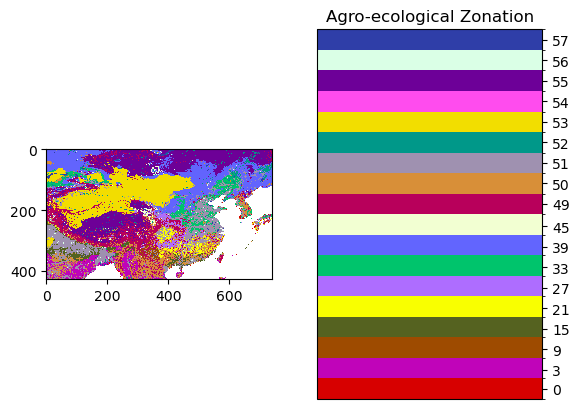

In [21]:
aez = clim_reg.AEZClassification(
    tclimate, lgp, lgp_equv, lgpt5, soil_terrain_lulc, permafrost)

import matplotlib.colors as colors
fig = plt.figure()
ax=fig.add_subplot(121)
cax=fig.add_subplot(122)
bounds=[-0.5,0.5,6.5,12.5,18.5,24.5,30.5,36.5,42.5,48.5,49.5,50.5,51.5,52.5,53.5,54.5,55.5,56.5,57.5]
ticks=[-1,0,3,9,15,21,27,33,39,45,49,50,51,52,53,54,55,56,57,59]
cmap=cc.cm.glasbey
norm=colors.BoundaryNorm(bounds,cmap.N)
# plt.imshow(aez, cmap=plt.get_cmap('rainbow', 59), vmin=0, vmax=59,interpolation='none')
# plt.imshow(aez, cmap=cmap, vmin=0, vmax=59,interpolation='none')
im=ax.imshow(aez, cmap=cmap, norm=norm, interpolation='none')
plt.title('Agro-ecological Zonation')
cbar=fig.colorbar(im,cax=cax,cmap=cmap,norm=norm, boundaries=bounds,ticks=ticks)
# plt.colorbar()

# plt.savefig(out_path+"AEZ_"+domain+"_"+revname+".png",bbox_inches="tight", dpi=600)
plt.show()
# obj_util.saveRaster(
#     mask_path, './data_output/NB1/LAO_aez.tif', aez)

obj_utilities.saveRaster(maskfile,out_path+"AEZ_"+domain+"_"+revname+".tif",aez) #Save as GeoTIFF raster



In [ ]:
aez_mask=np.where(aez==0,1,0)

In [ ]:
fig = plt.figure()
plt.imshow(aez_mask,interpolation='none')
plt.colorbar()

In [ ]:
for val in range(58):
    aez_lev=np.where(aez==val,1,0)
    fig = plt.figure()
    plt.imshow(aez_lev,interpolation='none')
    plt.title('aez='+str(val))
    plt.show()

In [ ]:
fig = plt.figure()
plt.imshow(clim_reg.aez_tclimate,cmap='tab10',interpolation='none')
plt.colorbar()

In [ ]:
fig = plt.figure()
plt.imshow(clim_reg.aez_tzone,cmap='tab10',interpolation='none')
plt.colorbar()

In [ ]:
fig = plt.figure()
plt.imshow(clim_reg.soil_terrain_lulc,cmap='tab10',interpolation='none')
plt.colorbar()

In [ ]:
fig = plt.figure()
plt.imshow(clim_reg.aez_temp_regime,cmap='tab10',interpolation='none')
plt.colorbar()

In [ ]:
fig = plt.figure()
plt.imshow(clim_reg.aez_moisture_regime,cmap='tab10',interpolation='none')
plt.colorbar()

<hr>

### END OF MODULE 1: CLIMATE REGIME

<hr>